# Customer Sentiment

<div style="text-align: center;" style="border: 2px solid black;">
    <img src="Apple store.png" alt="Apple Store" width="1000" height="400">
</div>

## Overview

This project uses Natural Language Processing to analyze sentiment from text.  We performed multiple models to predict emotion involved in tweets based on the data in order to provide Apple's Marketing Division an efficient tool to judge how customers feel about the company and its products.

## Business Problem

Create a model to predict negative emotion displayed in tweets about Apple products.

In [1]:
# import packages

import numpy as np
import pandas as pd
from collections import defaultdict

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

### Twitter Data

The data was sourced from CrowdFlower and included 9093 tweets posted around the 2011 SXSW Conference in Austin.  People from CrowdFlower judged these tweets to determine what type of emotional sentiment--positive, negative, or neutral--each tweet expressed.  If there was either a positive or negative emotional angle to a tweet, the brand or product that emotion was directed toward was also included in the data.  

There are some limitations to the data.  The sentiment labels were fairly imbalanced, including over 60% of them showing neither positive nor negative emotion and containing about 5 times as many positive tweets as negative ones.  There is also some likely demographic bias in our data.  This can occur by the people who are firing off the tweets, as well as by those who are judging the emotion of others' messaging.

In [2]:
# read in dataset

corpus = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')

In [3]:
corpus.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


## EDA

In [5]:
# drop the 1 row with a null tweet

corpus = corpus.dropna(subset = ['tweet_text'])
corpus = corpus.reset_index(drop=True)

In [6]:
# rename long column names

corpus.rename(columns = {'emotion_in_tweet_is_directed_at': 'emotion_directed_at',
                         'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion_type'}, inplace=True)

In [7]:
corpus['emotion_type'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion_type, dtype: int64

In [8]:
corpus['emotion_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_directed_at, dtype: int64

## Feature Engineering

In order to determine which tweets are directed toward Apple, we create a new numerical column to identify whether the brand is Apple or not.

In [9]:
# create brand lists that include the appropriate brands and products

Apple = ['iPad', 'Apple', 'iPad or iPhone App', 'iPhone', 'Other Apple product or service']


In [10]:
# create the numerical categories for brands

def target_brand(emotion_directed_at):
    if emotion_directed_at in Apple:
        return 1
    else:
        return 0

In [11]:
# add the new column

corpus['target_brand'] = corpus['emotion_directed_at'].apply(target_brand)

In [12]:
corpus['target_brand'].value_counts()

0    6683
1    2409
Name: target_brand, dtype: int64

In a new numerical column, we categorize the type of emotion in the tweet as positive, negative, or neutral.  Neutral includes instances where there was no emotion toward a brand or product found or where the evaluator couldn't tell.

In [13]:
# create groups of emotion types

Positive = ['Positive emotion']
Negative = ['Negative emotion']
Neutral = ['No emotion toward brand or product', "I can't tell"]

In [14]:
# create the numerical categories for emotion types

def target_emotion(emotion_type):
    if emotion_type in Positive:
        return 0
    if emotion_type in Negative:
        return 1
    if emotion_type in Neutral:
        return 2
    else:
        return 3

In [15]:
# add the new column

corpus['target_emotion'] = corpus['emotion_type'].apply(target_emotion)

In [16]:
corpus['target_emotion'].value_counts()

2    5544
0    2978
1     570
Name: target_emotion, dtype: int64

In [17]:
# create new dataframe with tweets with emotion directed at Apple

df_apple = corpus[(corpus['target_brand'] == 1) & (corpus['target_emotion'] < 2)]
df_apple = df_apple.reset_index(drop=True)
df_apple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   tweet_text           2337 non-null   object
 1   emotion_directed_at  2337 non-null   object
 2   emotion_type         2337 non-null   object
 3   target_brand         2337 non-null   int64 
 4   target_emotion       2337 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 91.4+ KB


In [18]:
df_apple['target_emotion'].value_counts(normalize=True)

0    0.833975
1    0.166025
Name: target_emotion, dtype: float64

We can now remove the columns we don't need and work with the tweets and target emotions going forward.

In [19]:
df_apple = df_apple.drop(['emotion_directed_at', 'emotion_type', 'target_brand'], axis =1)

In [20]:
# sanity check

df_apple.head()

,tweet_text,target_emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,0
2,@swonderlin Can not wait for #iPad 2 also. The...,0
3,@sxsw I hope this year's festival isn't as cra...,1
4,Beautifully smart and simple idea RT @madebyma...,0


After filtering the data by only including tweets where there was a sentiment toward Apple or its products, we have 2337 entries to work with in our models.

In [21]:
# create csv file of our filtered data set that we use for modeling

df_apple.to_csv('Apple_tweets.csv')

## Natural Language Processing (NLP)

We start with a train test split, placing 80% of the data in the train set and 20% in test.  The tweets are the independent variable, and the target is the emotion.  A negative emotion is 1, positive emotion is 0.

In [22]:
X = df_apple['tweet_text']
y = df_apple['target_emotion']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

### NLP Pre-processing

In [23]:
# adjust the nltk list of stopwords

sw = list(set(stopwords.words('english')) - {'not'})
sw.extend(['sxsw', 'austin', 'link', 'rt', 'among', 'mention'])

In [24]:
# transform the tags to parts of speech tags for the WordNetLemmatizer

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [25]:
# use a function to handle preprocessing steps

def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [26]:
# run the function on the X_train tweets

token_docs = [doc_preparer(doc, sw) for doc in X_train]

In [27]:
# sanity check

token_docs[-5:]

['look everyone zomg get ipad first day',
 'get ipad apple store thank much',
 'last not least get copy stupid game plus iphone also special price',
 'well ipad really perfect device',
 'holy smoke ipad replace flip cam default video capture device beautiful elegant apple']

### NLP Feature Engineering

In [29]:
# Secondary train-test split to build our best model

X_t, X_val, y_t, y_val = train_test_split(token_docs,
                                          y_train,
                                          test_size=0.2,
                                          random_state=42)

First, we use a Count Vectorizer to get the counts of all the tokens in each of the tweets.

In [30]:
# instantiate vectorizer and fit_transform it on the training set

cv = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw, analyzer='word')

X_t_cv = cv.fit_transform(X_t)
X_t_cv = pd.DataFrame.sparse.from_spmatrix(X_t_cv)
X_t_cv.columns = sorted(cv.vocabulary_)
X_t_cv.set_index(y_t.index, inplace=True)

In [31]:
X_t_cv

,aapl,abandon,aber,able,absolutely,abt,acceptable,access,accessibility,accessible,...,zazzlsxsw,zelda,zeldman,zero,zimride,zms,zombie,zomg,zone,zzzs
1077,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
389,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1913,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
243,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1880,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1070,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# transform vectorizer on the validation set

X_val_cv = cv.transform(X_val)
X_val_cv = pd.DataFrame.sparse.from_spmatrix(X_val_cv)
X_val_cv.columns = sorted(cv.vocabulary_)
X_val_cv.set_index(y_val.index, inplace=True)

In [33]:
X_val_cv

,aapl,abandon,aber,able,absolutely,abt,acceptable,access,accessibility,accessible,...,zazzlsxsw,zelda,zeldman,zero,zimride,zms,zombie,zomg,zone,zzzs
202,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1774,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
594,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
893,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
310,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
934,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
704,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's take a look at the top 10 most frequent words in our training set.

In [34]:
word_list = cv.get_feature_names_out()
#word_count = X_t_cv.toarray().sum(axis=0)
word_count = X_t_cv.sum(axis=0)


word_dict = dict(zip(word_list, word_count))
sorted_word_dict = dict(sorted(word_dict.items(), key=lambda item: item[1], reverse=True)[:10])
sorted_word_dict

{'ipad': 847,
 'apple': 610,
 'iphone': 425,
 'store': 338,
 'app': 228,
 'quot': 208,
 'get': 153,
 'new': 151,
 'pop': 137,
 'open': 106}

In [96]:
from collections import Counter
frequency_distribution = Counter(sorted_word_dict)

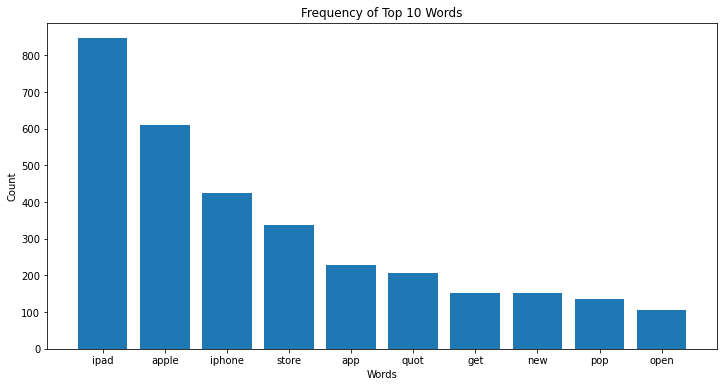

In [36]:
keys, values = zip(*frequency_distribution.items())

plt.figure(figsize=(12, 6))
plt.bar(keys, values)
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Frequency of Top 10 Words')
plt.show();

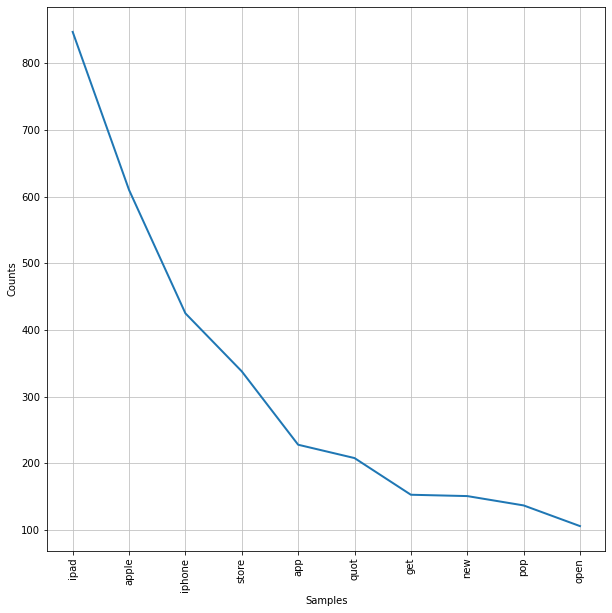

In [37]:
fdist = FreqDist(sorted_word_dict)
plt.figure(figsize=(10, 10))
fdist.plot(30);

The 3 most popular words related directly to Apple and its products, which isn’t surprising.  Now we'll look at the word counts in negative tweets only.

In [38]:
# pulling out the tweets with negative emotion

neg_tweets = df_apple[df_apple['target_emotion'] == 1]
neg_tweets = neg_tweets.reset_index(drop=True)
neg_tweets

,tweet_text,target_emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,1
1,@sxsw I hope this year's festival isn't as cra...,1
2,I just noticed DST is coming this weekend. How...,1
3,attending @mention iPad design headaches #sxsw...,1
4,What !?!? @mention #SXSW does not provide iPh...,1
...,...,...
383,If there was a popup store in Austin that sold...,1
384,#iPad #news #apps not popular with the #kids. ...,1
385,Hmmm...Taxi Magic on iPhone does not appear to...,1
386,I think my effing hubby is in line for an #iPa...,1


In [39]:
# run these tweets through the preprocessing function

neg_tweets_token = [doc_preparer(doc, sw) for doc in neg_tweets['tweet_text']]

In [40]:
# vectorize the tokens with the count vectorizer

neg_token_cv = cv.fit_transform(neg_tweets_token)
neg_token_cv = pd.DataFrame.sparse.from_spmatrix(neg_token_cv)
neg_token_cv.columns = sorted(cv.vocabulary_)
neg_token_cv

,abacus,abandon,abt,acc,acerbic,across,action,activate,actually,ad,...,yes,yesterday,yet,yonkers,york,z,zelda,zeldman,zone,zzzs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
384,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# create a dictionary of the top 25 most frequent tokens and their counts

neg_word_list = list(cv.get_feature_names_out())

neg_word_count = neg_token_cv.sum(axis=0)
neg_word_dict = dict(zip(neg_word_list, neg_word_count))

sorted_neg_word_dict = dict(sorted(neg_word_dict.items(), key=lambda item: item[1], reverse=True)[:25])
sorted_neg_word_dict

{'ipad': 196,
 'iphone': 152,
 'apple': 116,
 'quot': 115,
 'app': 47,
 'not': 45,
 'store': 43,
 'like': 35,
 'get': 31,
 'go': 26,
 'design': 25,
 'apps': 24,
 'new': 24,
 'people': 24,
 'amp': 20,
 'line': 20,
 'look': 19,
 'need': 19,
 'one': 19,
 'think': 19,
 'come': 18,
 'take': 18,
 'battery': 17,
 'day': 17,
 'time': 17}

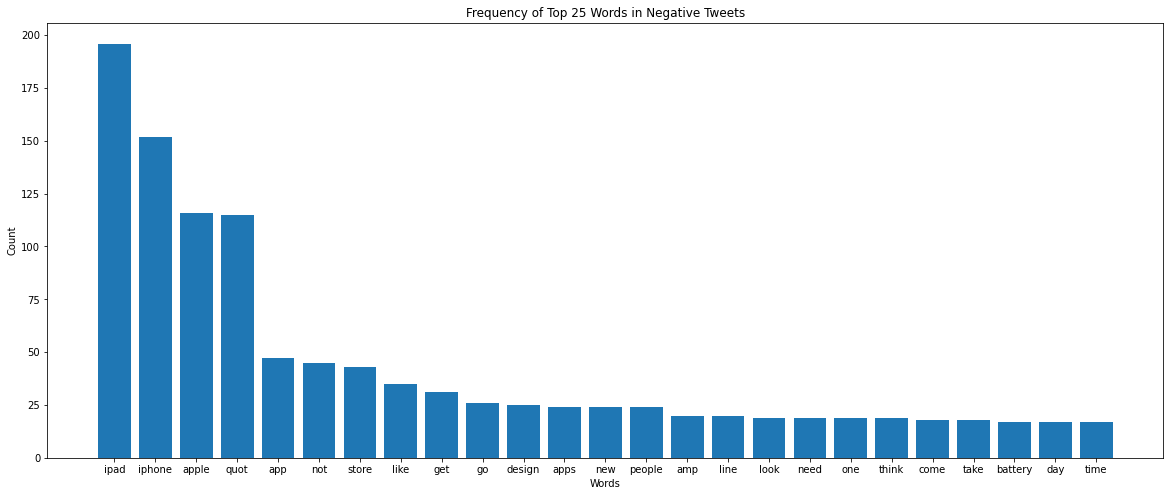

In [42]:
keys, values = zip(*sorted_neg_word_dict.items())

plt.figure(figsize=(20, 8))
plt.bar(keys, values)
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Frequency of Top 25 Words in Negative Tweets')
plt.show();

The Apple terms are still showing up the most in negative tweets.  Other interesting frequent words, however, are app, design, and battery.

In [43]:
# make a DataFrame with the keys and values in order to create a word cloud

word_count_df = pd.DataFrame(sorted_neg_word_dict.items(), columns=['word', 'weight'])
cols = word_count_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
word_count_df = word_count_df[cols]
word_count_df

,weight,word
0,196,ipad
1,152,iphone
2,116,apple
3,115,quot
4,47,app
5,45,not
6,43,store
7,35,like
8,31,get
9,26,go


In [44]:
word_count_df.to_csv('negative_word_count.csv')

<div style="text-align: center;" style="border: 2px solid black;">
    <img src="word cloud.png" alt="word cloud" width="400" height="400">
</div>

We want to determine which of the Apple, iPhone, and iPad has generated the greatest ratio of negative reaction.

In [45]:
#Visualization of Postive and Negative Emotion Tweets for Apple Products

df_apple['product'] = ''
for i in range(len(df_apple['tweet_text'])):
    string = df_apple['tweet_text'][i]

    if isinstance(string, str):
        if 'ipad' in string.lower():
            df_apple.at[i, 'product'] = 'ipad'
        elif 'iphone' in string.lower():
            df_apple.at[i, 'product'] = 'iphone'
        elif 'apple' in string.lower():
            df_apple.at[i, 'product'] = 'apple'
        else:
            df_apple.at[i, 'product'] = 'none'
                

In [46]:
# sanity check

df_apple.head()

,tweet_text,target_emotion,product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,1,iphone
1,@jessedee Know about @fludapp ? Awesome iPad/i...,0,ipad
2,@swonderlin Can not wait for #iPad 2 also. The...,0,ipad
3,@sxsw I hope this year's festival isn't as cra...,1,iphone
4,Beautifully smart and simple idea RT @madebyma...,0,ipad


In [47]:
df_apple['product'].value_counts()

ipad      1273
iphone     556
apple      480
none        28
Name: product, dtype: int64

In [48]:
ipad = df_apple[df_apple['product'] == 'iphone']
ipad['target_emotion'].value_counts(normalize=True)

0    0.753597
1    0.246403
Name: target_emotion, dtype: float64

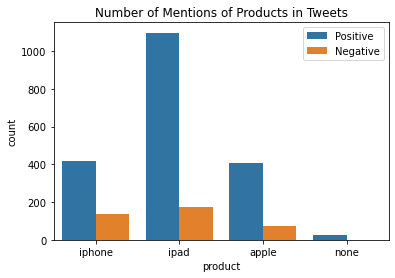

In [49]:
# Create a count plot

ax = sns.countplot(data=df_apple, x = "product", hue="target_emotion")
ax.legend(['Positive', 'Negative'])
ax.set_title('Number of Mentions of Products in Tweets')
# Show the plot
plt.show()

This shows that while the iPad was mentioned much more often by people, their negativity was brought out at a higher rate when discussing the iPhone.

We'll also want to try the TF-IDF Vectorizer in the models.

In [50]:
# instantiate vectorizer and fit_transform it on the training set

tf = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw, analyzer='word')

X_t_tf = tf.fit_transform(X_t)
X_t_tf = pd.DataFrame.sparse.from_spmatrix(X_t_tf)
X_t_tf.columns = sorted(tf.vocabulary_)
X_t_tf.set_index(y_t.index, inplace=True)

In [51]:
# transform vectorizer on the validation set

X_val_tf = tf.transform(X_val)
X_val_tf = pd.DataFrame.sparse.from_spmatrix(X_val_tf)
X_val_tf.columns = sorted(tf.vocabulary_)
X_val_tf.set_index(y_val.index, inplace=True)

## Modeling

We will build a baseline model with a Multinomial Naive Bayes classifier.

In [52]:
# create a pipeline to vectorize and run Multinomial Naive Bayes model

pipe_mnb = Pipeline([('cv', cv), ('mnb', MultinomialNB(alpha=0.1))])

In [53]:
# fit the pipeline on the train set

pipe_mnb.fit(X_t, y_t)

Pipeline(steps=[('cv',
                 CountVectorizer(stop_words=['had', 'haven', 'those', "hadn't",
                                             'an', 'more', 'too', 'any', 'just',
                                             "couldn't", 'ourselves', 'up',
                                             'then', 'when', 'doesn', 'hasn',
                                             'me', 'what', 'as', 'herself',
                                             'only', 'other', 'i', 'won', 'so',
                                             'these', 'below', 're',
                                             'themselves', 'it', ...],
                                 token_pattern="([a-zA-Z]+(?:'[a-z]+)?)")),
                ('mnb', MultinomialNB(alpha=0.1))])

In [54]:
# run cross validation

cross_val_score(pipe_mnb, X_t, y_t, cv=10)

array([0.84666667, 0.82      , 0.80666667, 0.84666667, 0.82666667,
       0.87919463, 0.85234899, 0.83892617, 0.87919463, 0.86577181])

In [55]:
# make predictions for y

y_hat = pipe_mnb.predict(X_val)

In [56]:
# metrics for baseline model

accuracy = accuracy_score(y_val, y_hat)
classification_rep = classification_report(y_val, y_hat)
conf_matrix = confusion_matrix(y_val, y_hat)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:f}")
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.898396

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       314
           1       0.71      0.62      0.66        60

    accuracy                           0.90       374
   macro avg       0.82      0.78      0.80       374
weighted avg       0.89      0.90      0.90       374


Confusion Matrix:
[[299  15]
 [ 23  37]]


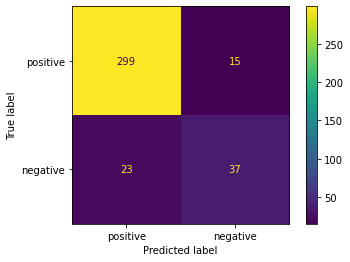

In [57]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['positive', 'negative'])
cm_display.plot()
plt.show()

We use GridSearch CV to adjust some hyperparameters to look for a better model.

In [58]:
# select parameters for ngrams, max features, and Laplace smoothing

params = {'cv__ngram_range': [(1, 1), (2, 2), (1, 2)],
          'cv__max_features': [5, 10, 15],
          'mnb__alpha': [0.1, 1, 10]}

gs = GridSearchCV(estimator=pipe_mnb,
                  param_grid = params,
                  cv=10)

In [59]:
gs.fit(X_t, y_t)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(stop_words=['had',
                                                                    'haven',
                                                                    'those',
                                                                    "hadn't",
                                                                    'an',
                                                                    'more',
                                                                    'too',
                                                                    'any',
                                                                    'just',
                                                                    "couldn't",
                                                                    'ourselves',
                                                                    'up',
                                                                    'then',
                                                                    'when',
                                                                    'doesn',
                                                                    'hasn',
                                                                    'me',
                                                                    'what',
                                                                    'as',
                                                                    'herself',
                                                                    'only',
                                                                    'other',
                                                                    'i', 'won',
                                                                    'so',
                                                                    'these',
                                                                    'below',
                                                                    're',
                                                                    'themselves',
                                                                    'it', ...],
                                                        token_pattern="([a-zA-Z]+(?:'[a-z]+)?)")),
                                       ('mnb', MultinomialNB(alpha=0.1))]),
             param_grid={'cv__max_features': [5, 10, 15],
                         'cv__ngram_range': [(1, 1), (2, 2), (1, 2)],
                         'mnb__alpha': [0.1, 1, 10]})

In [60]:
# see the best parameters for the model

gs.best_params_

{'cv__max_features': 5, 'cv__ngram_range': (1, 1), 'mnb__alpha': 0.1}

In [61]:
gs.cv_results_['mean_test_score'].max()

0.8240850111856822

In [62]:
# set up a pipeline with TF-IDF vectorization and Multinomial Naive Bayes

pipe_mnb_tf = Pipeline([('tf', tf), ('mnb', MultinomialNB(alpha=0.1))])

In [63]:
# fit the pipeline on the train set

pipe_mnb_tf.fit(X_t, y_t)

Pipeline(steps=[('tf',
                 TfidfVectorizer(stop_words=['had', 'haven', 'those', "hadn't",
                                             'an', 'more', 'too', 'any', 'just',
                                             "couldn't", 'ourselves', 'up',
                                             'then', 'when', 'doesn', 'hasn',
                                             'me', 'what', 'as', 'herself',
                                             'only', 'other', 'i', 'won', 'so',
                                             'these', 'below', 're',
                                             'themselves', 'it', ...],
                                 token_pattern="([a-zA-Z]+(?:'[a-z]+)?)")),
                ('mnb', MultinomialNB(alpha=0.1))])

In [64]:
# run cross validation

cross_val_score(pipe_mnb_tf, X_t, y_t, cv=10)

array([0.86666667, 0.81333333, 0.83333333, 0.86666667, 0.84      ,
       0.90604027, 0.86577181, 0.85234899, 0.87919463, 0.87248322])

In [65]:
# make predictions for y

y_hat_tf = pipe_mnb_tf.predict(X_val)

In [66]:
# metrics for TF-IDF model

accuracy = accuracy_score(y_val, y_hat_tf)
classification_rep = classification_report(y_val, y_hat_tf)
conf_matrix = confusion_matrix(y_val, y_hat_tf)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:f}")
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.895722

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       314
           1       0.89      0.40      0.55        60

    accuracy                           0.90       374
   macro avg       0.89      0.70      0.75       374
weighted avg       0.90      0.90      0.88       374


Confusion Matrix:
[[311   3]
 [ 36  24]]


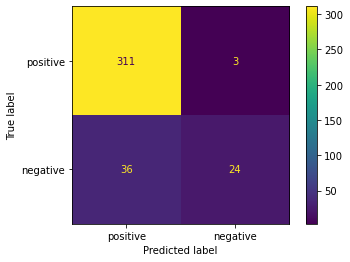

In [67]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['positive', 'negative'])
cm_display.plot()
plt.show()

We want to look at an alternative classifier model, so we will perform Random Forest.

In [68]:
# Initiate the random forest, fit it on the train set, and predict y

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_t_cv, y_t)
y_hat_rf = rf.predict(X_val_cv)


In [69]:
# accuracy for the random forest

accuracy = accuracy_score(y_val, y_hat_rf)
print(f"Accuracy: {accuracy:f}")


Accuracy: 0.895722


The Random Forest doesn't predict the sentiment quite as accurately as the Multinomial Naive Bayes.  We'll use the feature importance from the random forest to focus on the top 10 features for another Multinomial Naive Bayes model.

In [70]:
# Feature Importances

feat_import = {name: score 
                   for name, score 
                       in zip(X_t_cv.columns, rf.feature_importances_)
}
feat_import

{'aapl': 8.1495845782874e-05,
 'abandon': 0.0007546127425269708,
 'aber': 3.3974758595136653e-07,
 'able': 2.4661014010555496e-06,
 'absolutely': 0.0,
 'abt': 0.0002007605254682953,
 'acceptable': 6.867841157101541e-05,
 'access': 4.11914513798046e-06,
 'accessibility': 0.0,
 'accessible': 0.0,
 'accessory': 1.0165214943834463e-07,
 'accommodate': 2.391543377838427e-07,
 'accordion': 0.0,
 'acerbic': 0.0001887121031777482,
 'acquire': 4.604445236033884e-06,
 'across': 0.000163292950953016,
 'acrosse': 6.822128937977273e-05,
 'action': 0.00010571364799116297,
 'activity': 9.451889525945535e-05,
 'actor': 0.0,
 'actsofsharing': 2.7542266978898348e-05,
 'actual': 8.682839253032957e-06,
 'actually': 0.00018946299032499166,
 'ad': 0.0006049327937257061,
 'adam': 1.3561907224526974e-06,
 'add': 6.06843815963649e-06,
 'added': 3.482434676646537e-08,
 'addict': 8.50529232338341e-05,
 'addictedtotheinterwebs': 1.1071328728053755e-05,
 'additional': 1.931570466274649e-06,
 'admission': 0.0,
 'ad

In [71]:
# max feature importance

max_feature = max(feat_import, key=lambda k: feat_import[k])

print(f"The feature with the greatest importance is: {max_feature}")
print(f"Importance Score: {feat_import[max_feature]}")

The feature with the greatest importance is: headache
Importance Score: 0.015350968943502564


In [72]:
# top 10 features

top_features = sorted(feat_import.items(), key=lambda x: x[1], reverse=True)[:10]

# print the top 10 features and their scores

print("Top 10 features:")
for feature, importance in top_features:
    print(f"{feature}: {importance}")

Top 10 features:
headache: 0.015350968943502564
suck: 0.012665826953342212
iphone: 0.009215250368115548
ipad: 0.008983919573433618
fail: 0.008587118584456014
hate: 0.008297485773021536
battery: 0.00799553851874597
fade: 0.007719793331596329
money: 0.006812852262205443
fuck: 0.006721920584944927


In [73]:
top_feature_names = [feature for feature, _ in top_features]

# Create a subset of your data with only the top features
X_subset = X_t_cv[top_feature_names].values  # Use .values to get the underlying NumPy array

# Convert X_subset to a DataFrame
X_subset_df = pd.DataFrame(X_subset, columns=top_feature_names)

# Include the original DataFrame along with the top features
X_t_cv.reset_index(drop=True, inplace=True)
X_subset_df.reset_index(drop=True, inplace=True)
X_original_and_top_features = pd.concat([X_t_cv, X_subset_df], axis=1)

# predict 'target_emotion'
y_subset_df = pd.DataFrame(y_t).values  # Use .values to get the underlying NumPy array

# Ensure X and y have the same number of samples
min_samples = min(X_original_and_top_features.shape[0], y_subset_df.shape[0])
X_original_and_top_features = X_original_and_top_features.iloc[:min_samples, :]
y_subset_df = y_subset_df[:min_samples]

# Split the data into training and testing sets
X_t_top_feat, X_val_top_feat, y_t_top_feat, y_val_top_feat = train_test_split(X_original_and_top_features, y_subset_df, test_size=0.2, random_state=42)

# Train a Multinomial Naive Bayes classifier
mnb_top_feat = MultinomialNB()
mnb_top_feat.fit(X_t_top_feat, y_t_top_feat.ravel())

c:\Users\dangr\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:785: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


MultinomialNB()

In [74]:
# Make predictions on the test set

y_hat_top_feat = mnb_top_feat.predict(X_val_top_feat)

accuracy = accuracy_score(y_val_top_feat, y_hat_top_feat)
classification_rep = classification_report(y_val_top_feat, y_hat_top_feat)
cm_top_feat = confusion_matrix(y_val_top_feat, y_hat_top_feat)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:f}")
print("\nClassification Report:")
print(classification_rep)

Accuracy: 0.856187

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       243
           1       0.64      0.52      0.57        56

    accuracy                           0.86       299
   macro avg       0.77      0.73      0.74       299
weighted avg       0.85      0.86      0.85       299



c:\Users\dangr\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:785: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


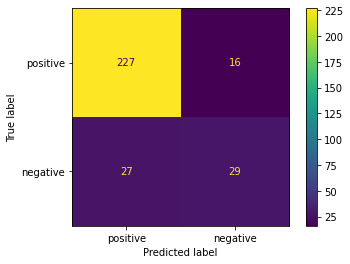

In [75]:
cm_top_feat_disp = ConfusionMatrixDisplay(confusion_matrix=cm_top_feat, display_labels=['positive', 'negative'])
cm_top_feat_disp.plot()
plt.show()

Using the top features according to the Random Forest in our Multinomial Naive Bayes doesn't increase the accuracy of our model.

### Balanced Target Variable

Given the significant imbalance between tweets with positive emotion (majority class) and tweets showing negative emotion (minority class), we'll try undersampling the majority class to balance our data.

In [76]:
# create DataFrame for sampling

train_df = pd.concat([X_train, y_train], axis=1)
train_df

,tweet_text,target_emotion
1573,"RT @mention Hey, you lucky dogs at #SXSW with ...",0
65,I went to #sxswi and all I won was this lousy ...,0
1251,"LOL, I don't see a single PC user around meÛÓ...",0
353,Attending TV + New Media = Formula for Success...,0
700,Download Daily Grape - a new app from @mentio...,0
...,...,...
1638,RT @mention Look everyone! Zomg @mention got a...,0
1095,@mention just got me an iPad from #SXSW Apple ...,0
1130,@mention Last but not least get a copy of Stu...,0
1294,Well having the iPad has really been the perfe...,0


In [77]:
# reduce count of positive emotion to equal that of negative emotion

pos = train_df[train_df['target_emotion'] == 0]
neg = train_df[train_df['target_emotion'] == 1]
pos_undersample = pos.sample(n=len(neg), random_state=42)
train_df_bal = pd.concat([neg, pos_undersample], axis=0)

In [78]:
# sanity check

train_df_bal['target_emotion'].value_counts()

1    323
0    323
Name: target_emotion, dtype: int64

Now we can try our models again with the balanced data.

In [79]:
# Secondary train-test split to build our best model

X_train_bal = train_df_bal['tweet_text']
y_train_bal = train_df_bal['target_emotion']

X_t_bal, X_val_bal, y_t_bal, y_val_bal = train_test_split(X_train_bal,
                                          y_train_bal,
                                          test_size=0.15,
                                          random_state=42)

In [80]:
# use the same count vectorizer - fit_transform on train set, transform on validation set

X_t_bal_cv = cv.fit_transform(X_t_bal)
X_t_bal_cv = pd.DataFrame.sparse.from_spmatrix(X_t_bal_cv)
X_t_bal_cv.columns = sorted(cv.vocabulary_)
X_t_bal_cv.set_index(y_t_bal.index, inplace=True)

X_val_bal_cv = cv.transform(X_val_bal)
X_val_bal_cv = pd.DataFrame.sparse.from_spmatrix(X_val_bal_cv)
X_val_bal_cv.columns = sorted(cv.vocabulary_)
X_val_bal_cv.set_index(y_val_bal.index, inplace=True)

In [81]:
# fit the pipe_mnb pipeline on the balanced train set

pipe_mnb.fit(X_t_bal, y_t_bal)

Pipeline(steps=[('cv',
                 CountVectorizer(stop_words=['had', 'haven', 'those', "hadn't",
                                             'an', 'more', 'too', 'any', 'just',
                                             "couldn't", 'ourselves', 'up',
                                             'then', 'when', 'doesn', 'hasn',
                                             'me', 'what', 'as', 'herself',
                                             'only', 'other', 'i', 'won', 'so',
                                             'these', 'below', 're',
                                             'themselves', 'it', ...],
                                 token_pattern="([a-zA-Z]+(?:'[a-z]+)?)")),
                ('mnb', MultinomialNB(alpha=0.1))])

In [82]:
# run cross validation

cross_val_score(pipe_mnb, X_t_bal, y_t_bal, cv=10)

array([0.69090909, 0.67272727, 0.54545455, 0.74545455, 0.67272727,
       0.78181818, 0.69090909, 0.76363636, 0.67272727, 0.72222222])

In [83]:
# predict the y validation set

y_hat_bal = pipe_mnb.predict(X_val_bal)

In [84]:
accuracy_bal = accuracy_score(y_val_bal, y_hat_bal)
classification_rep_bal = classification_report(y_val_bal, y_hat_bal)
conf_matrix_bal = confusion_matrix(y_val_bal, y_hat_bal)

# Print the evaluation metrics
print(f"Accuracy: {accuracy_bal:f}")
print("\nClassification Report:")
print(classification_rep_bal)
print("\nConfusion Matrix:")
print(conf_matrix_bal)

Accuracy: 0.742268

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.81      0.71        37
           1       0.86      0.70      0.77        60

    accuracy                           0.74        97
   macro avg       0.74      0.76      0.74        97
weighted avg       0.77      0.74      0.75        97


Confusion Matrix:
[[30  7]
 [18 42]]


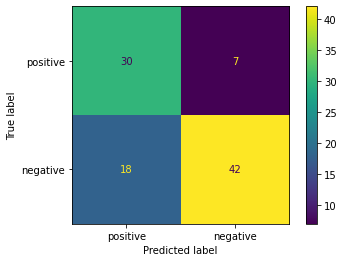

In [85]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bal, display_labels=['positive', 'negative'])
cm_display.plot()
plt.show()

Balancing the data made the accuracy worse.  We'll use the GridSearchCV to try to find better parameters.

In [86]:
# fit our GridSearchCV on the balanced training set

gs.fit(X_t_bal, y_t_bal)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(stop_words=['had',
                                                                    'haven',
                                                                    'those',
                                                                    "hadn't",
                                                                    'an',
                                                                    'more',
                                                                    'too',
                                                                    'any',
                                                                    'just',
                                                                    "couldn't",
                                                                    'ourselves',
                                                                    'up',
                                                                    'then',
                                                                    'when',
                                                                    'doesn',
                                                                    'hasn',
                                                                    'me',
                                                                    'what',
                                                                    'as',
                                                                    'herself',
                                                                    'only',
                                                                    'other',
                                                                    'i', 'won',
                                                                    'so',
                                                                    'these',
                                                                    'below',
                                                                    're',
                                                                    'themselves',
                                                                    'it', ...],
                                                        token_pattern="([a-zA-Z]+(?:'[a-z]+)?)")),
                                       ('mnb', MultinomialNB(alpha=0.1))]),
             param_grid={'cv__max_features': [5, 10, 15],
                         'cv__ngram_range': [(1, 1), (2, 2), (1, 2)],
                         'mnb__alpha': [0.1, 1, 10]})

In [87]:
gs.best_params_

{'cv__max_features': 15, 'cv__ngram_range': (1, 1), 'mnb__alpha': 0.1}

In [88]:
gs.cv_results_['mean_test_score'].max()

0.6356902356902357

No combination of those hyperparameters helped our model.

### Evaluation on Test Set Data

The model providing our best result for its accuracy in predicting the correct type of emotion was the base Multinomial Naive Bayes model with count vectorization.  This model gave us the highest recall score as well, so it is the best at avoiding the identification of a negative tweet as one with positive sentiment.  Let's see how this best model handles the test set.

In [89]:
X_train_cv = cv.fit_transform(token_docs)

X_train_cv = pd.DataFrame.sparse.from_spmatrix(X_train_cv)
X_train_cv.columns = sorted(cv.vocabulary_)
X_train_cv.set_index(y_train.index, inplace=True)

In [90]:
best_model = MultinomialNB(alpha=0.1)

best_model.fit(X_train_cv, y_train)
best_model.score(X_train_cv, y_train)

0.980203317281969

In [91]:
# run the preprocessing function on X_test

token_test = [doc_preparer(doc, sw) for doc in X_test]

In [92]:
X_test_cv = cv.transform(token_test)

X_test_cv = pd.DataFrame.sparse.from_spmatrix(X_test_cv)
X_test_cv.columns = sorted(cv.vocabulary_)
X_test_cv.set_index(y_test.index, inplace=True)

In [93]:
y_hat_test = best_model.predict(X_test_cv)

In [94]:
accuracy_test = accuracy_score(y_test, y_hat_test)
classification_rep_test = classification_report(y_test, y_hat_test)
conf_matrix_test = confusion_matrix(y_test, y_hat_test)

# Print the evaluation metrics
print(f"Accuracy: {accuracy_test:f}")
print("\nClassification Report:")
print(classification_rep_test)
print("\nConfusion Matrix:")
print(conf_matrix_test)

Accuracy: 0.880342

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       403
           1       0.57      0.60      0.58        65

    accuracy                           0.88       468
   macro avg       0.75      0.76      0.76       468
weighted avg       0.88      0.88      0.88       468


Confusion Matrix:
[[373  30]
 [ 26  39]]


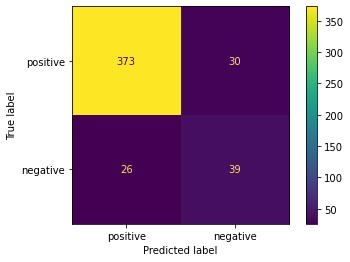

In [95]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=['positive', 'negative'])
cm_display.plot()
plt.show()

## Assessment

After tuning the hyperparameters on both Multinomial Naive Bayes and Random Forest Classification models, as well as balancing the data by the target variable of negative emotion, we have found a model that accurately predicts whether or not a tweet has negative sentiment 88% of the time.

## Recommendations

- **Battery life**  

Work to improve the battery life in iPhones, as this was a common complaint among customers.

- **iPad accessories**  

Given the large number of positive messages about the iPad, find ways to expand the offerings related to this device.

- **Thorough partnership and rollout planning**